# All of the jMotif Toy Examples from the github repository

Essentially a replication of the examples on: https://github.com/jMotif/jmotif-R

In [12]:
library(jmotif)

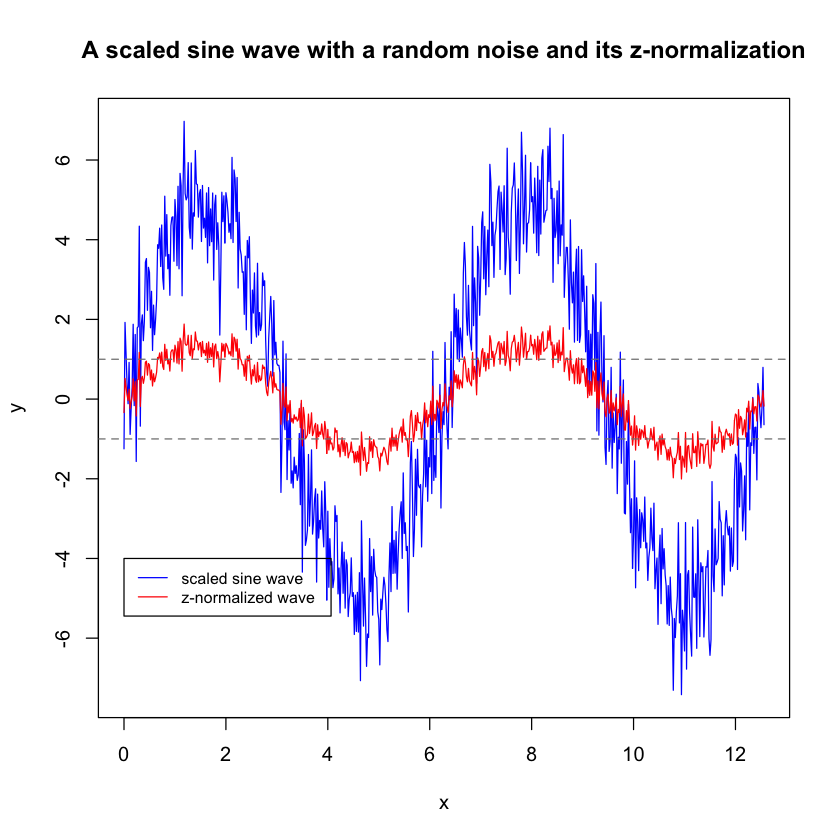

In [13]:
x = seq(0, pi*4, 0.02)
y = sin(x) * 5 + rnorm(length(x))

plot(x, y, type="l", col="blue", main="A scaled sine wave with a random noise and its z-normalization")

lines(x, znorm(y, 0.01), type="l", col="red")
abline(h=c(1,-1), lty=2, col="gray50")
legend(0, -4, c("scaled sine wave","z-normalized wave"), lty=c(1,1), lwd=c(1,1), 
                                                                col=c("blue","red"), cex=0.8)

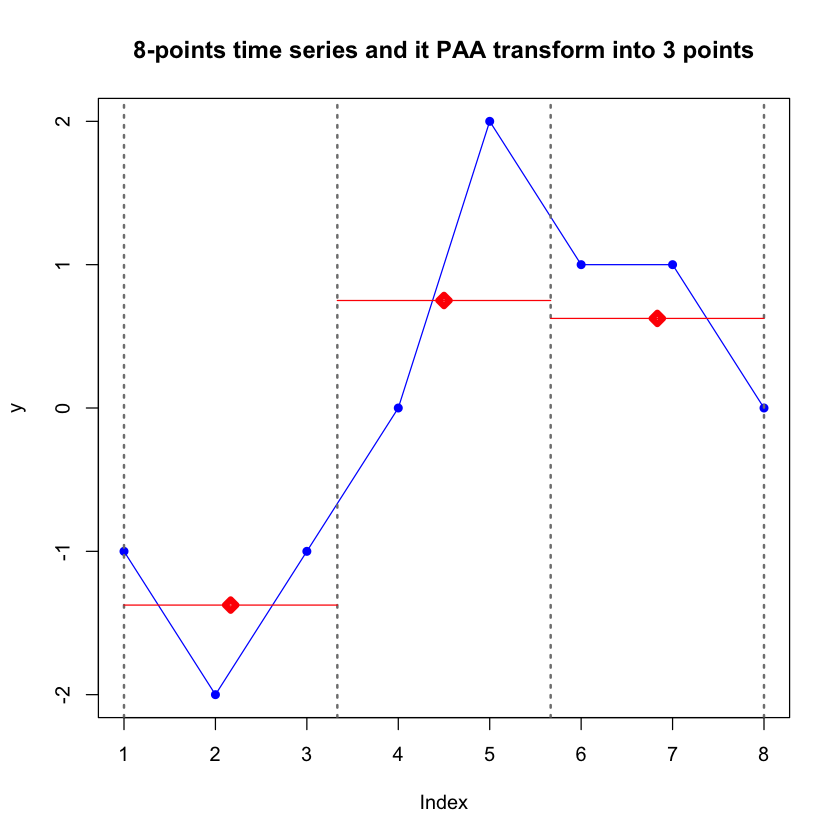

In [14]:
y = c(-1, -2, -1, 0, 2, 1, 1, 0)
plot(y, type="l", col="blue", main="8-points time series and it PAA transform into 3 points")

points(y, pch=16, lwd=5, col="blue")

abline(v=c(1,1+7/3,1+7/3*2,8), lty=3, lwd=2, col="gray50")

y_paa3 = paa(y, 3)

segments(1,y_paa3[1],1+7/3,y_paa3[1],lwd=1,col="red")
points(x=1+7/3/2,y=y_paa3[1],col="red",pch=23,lwd=5)

segments(1+7/3,y_paa3[2],1+7/3*2,y_paa3[2],lwd=1,col="red")
points(x=1+7/3+7/3/2,y=y_paa3[2],col="red",pch=23,lwd=5)

segments(1+7/3*2,y_paa3[3],8,y_paa3[3],lwd=1,col="red")
points(x=1+7/3*2+7/3/2,y=y_paa3[3],col="red",pch=23,lwd=5)

In [17]:
data("CBF")

In [18]:
str(CBF)

List of 4
 $ labels_train: num [1:30] 1 1 1 3 2 2 1 3 2 1 ...
 $ data_train  : num [1:30, 1:128] -0.464 -0.897 -0.465 -0.187 -1.136 ...
 $ labels_test : num [1:900] 2 2 1 2 2 3 1 3 2 3 ...
 $ data_test   : num [1:900, 1:128] -1.517 -0.703 -1.412 -0.955 -1.449 ...


In [19]:
w <- 60 # the sliding window size
p <- 6  # the PAA size
a <- 6  # the SAX alphabet size

# convert the train classes to wordbags (the dataset has three labels: 1, 2, 3)
#
cylinder <- manyseries_to_wordbag(CBF[["data_train"]][CBF[["labels_train"]] == 1,], w, p, a, "exact", 0.01)
bell <- manyseries_to_wordbag(CBF[["data_train"]][CBF[["labels_train"]] == 2,], w, p, a, "exact", 0.01)
funnel <- manyseries_to_wordbag(CBF[["data_train"]][CBF[["labels_train"]] == 3,], w, p, a, "exact", 0.01)

In [20]:
head(cylinder)

,words,counts
1,aabeee,2
2,aabeef,1
3,aaceee,7
4,aacfee,1
5,aadeee,7
6,aaedde,1


In [25]:
tfidf = bags_to_tfidf( list("cylinder" = cylinder, "bell" = bell, "funnel" = funnel) )


In [27]:
tail(tfidf)

,words,cylinder,bell,funnel
646,ffcbbb,0.6525709,0.562094,0
647,ffdbab,0,0,0.7615
648,ffdbbb,1.968449,0,0
649,ffdcaa,0,0,0.7615
650,ffdcba,0,0,0.7615
651,ffebbb,1.523,0,0


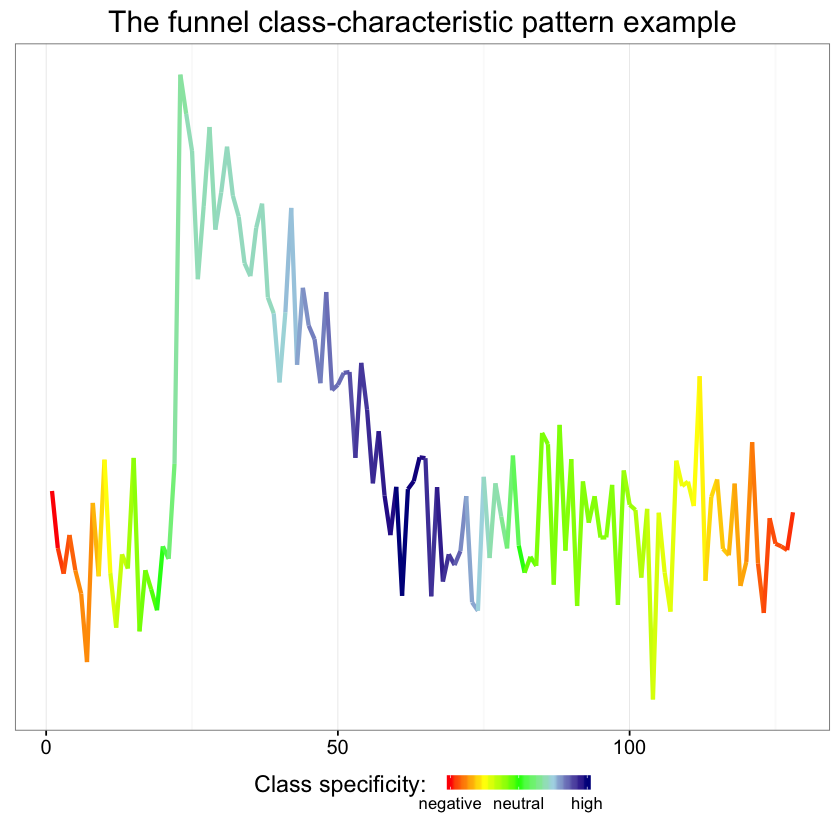

In [28]:
# make up a sample time-series
#
sample = (CBF[["data_train"]][CBF[["labels_train"]] == 3,])[1,]
sample_bag = sax_via_window(sample, w, p, a, "exact", 0.01)
df = data.frame(index = as.numeric(names(sample_bag)), words = unlist(sample_bag))

# weight the found patterns
#
weighted_patterns = merge(df, tfidf)
specificity = rep(0, length(sample))
for(i in 1:length(weighted_patterns$words)){
  pattern = weighted_patterns[i,]
  for(j in 1:w){
    specificity[pattern$index+j] = specificity[pattern$index+j] +
                                        pattern$funnel - pattern$bell - pattern$cylinder
  }
}

# plot the weighted patterns
#
library(ggplot2)
library(scales)
ggplot(data=data.frame(x=c(1:length(sample)), y=sample, col=rescale(specificity)),
 aes(x=x,y=y,color=col)) + geom_line(size=1.2) + theme_bw() +
 ggtitle("The funnel class-characteristic pattern example") +
 scale_colour_gradientn(name = "Class specificity:  ",limits=c(0,1),
    colours=c("red","yellow","green","lightblue","darkblue"),
    breaks=c(0,0.5,1),labels=c("negative","neutral","high"),
    guide = guide_colorbar(title.theme=element_text(size=14, angle=0),title.vjust=1,
    barheight=0.6, barwidth=6, label.theme=element_text(size=10, angle=0))) +
 theme(legend.position="bottom",plot.title=element_text(size=18),
    axis.title.x=element_blank(), axis.title.y=element_blank(),
    axis.text.x=element_text(size=12),axis.text.y=element_blank(),
    panel.grid.major.y = element_blank(), panel.grid.minor.y = element_blank(),
    axis.ticks.y = element_blank())

In [30]:
# classify the test data
#
labels_predicted = rep(-1, length(CBF[["labels_test"]]))
labels_test = CBF[["labels_test"]]
data_test = CBF[["data_test"]]
for (i in c(1:length(data_test[,1]))) {
    series = data_test[i,]
    bag = series_to_wordbag(series, w, p, a, "exact", 0.01)
    cosines = cosine_sim(list("bag"=bag, "tfidf" = tfidf))
    labels_predicted[i] = which(cosines$cosines == max(cosines$cosines))
}

# compute the classification error
#
error = length(which((labels_test != labels_predicted))) / length(labels_test)
print(error)

# findout which time series were misclassified
#
which((labels_test != labels_predicted))

[1] 0


integer(0)

In [31]:
print(cosines)

   classes     cosines
1 cylinder 0.362611671
2     bell 0.002417178
3   funnel 0.057447869


In [32]:
labels_predicted

[1] 2 2 1 2 2 3 1 3 2 3 2 1 3 2 2 3 3 2 2 1 2 2 2 1 2 3 3 3 1 3 2 2 1 3 2 3 1
 [38] 3 3 3 2 2 2 2 2 1 2 3 1 2 3 1 3 1 2 1 3 3 3 3 2 1 3 1 3 1 1 3 2 1 2 3 3 1
 [75] 2 2 2 2 3 2 1 1 1 1 3 3 3 1 3 1 3 1 2 2 1 2 3 3 1 3 2 2 1 3 2 3 3 3 1 1 3
[112] 1 1 3 3 3 2 1 2 3 3 3 1 1 2 3 1 1 2 3 3 1 1 3 3 2 2 1 1 1 2 1 2 3 3 2 3 1
[149] 2 1 3 3 2 1 3 2 1 2 3 1 2 3 2 2 3 1 2 3 3 1 2 3 1 1 3 1 2 1 3 1 2 1 2 3 2
[186] 3 2 1 1 2 3 2 3 1 1 1 3 2 3 1 2 3 2 2 1 2 1 3 2 3 2 2 2 3 2 2 3 2 1 2 1 3
[223] 3 3 2 1 1 3 3 3 2 3 3 1 2 2 1 2 1 3 2 1 2 1 2 3 1 1 3 1 1 2 1 1 2 3 3 3 1
[260] 2 3 3 1 1 3 2 3 2 2 1 2 2 1 1 1 3 2 2 1 1 3 3 1 2 3 3 2 2 3 2 1 3 2 1 1 3
[297] 2 1 2 2 2 3 3 1 2 3 3 1 3 2 3 1 2 3 1 2 1 1 1 3 3 1 2 3 3 1 1 2 3 1 1 1 3
[334] 2 3 1 2 2 2 1 1 2 2 3 2 3 3 1 2 1 1 1 2 2 1 2 3 2 1 1 1 3 3 3 3 3 2 2 2 3
[371] 2 2 3 2 3 1 3 3 2 1 3 3 3 1 2 1 1 3 2 3 1 2 2 2 1 3 1 1 3 1 2 1 3 2 1 2 1
[408] 1 3 2 1 1 1 1 3 2 3 3 2 2 1 2 3 3 3 1 3 3 2 3 3 1 1 2 1 1 2 1 2 2 2 2 1 3
[445] 2 3 3 3 3 1 3 2 1 2 1 1 3 3 2 1 1 2 1 3 1 2 2 2 3 2 1 3 3 3 1 1 2 1 1 3 3
[482] 1 3 2 3 3 3 1 2 2 3 1 2 1 2 2 3 3 1 1 2 2 3 2 2 2 3 2 2 1 2 1 2 1 3 3 2 2
[519] 1 3 2 2 3 1 3 3 3 1 3 1 1 1 2 2 2 1 3 3 3 1 3 1 3 3 3 3 3 2 1 2 2 3 2 1 3
[556] 1 2 2 1 2 3 1 1 3 3 2 3 2 3 1 3 2 3 1 1 1 1 1 2 3 2 2 1 3 2 1 2 3 1 3 1 2
[593] 3 2 2 2 2 1 1 3 1 1 2 1 1 3 3 2 1 3 1 2 3 3 2 3 3 1 2 3 3 2 3 2 1 1 3 3 2
[630] 3 3 2 1 2 1 3 2 1 1 2 3 2 2 1 3 1 3 1 1 1 2 1 1 3 3 1 2 3 2 1 1 2 2 3 2 2
[667] 3 3 1 1 1 2 2 3 2 3 2 2 1 2 2 1 3 1 1 1 3 3 2 3 3 1 3 1 1 2 1 1 3 2 2 2 3
[704] 1 1 1 1 1 2 2 2 2 2 3 1 2 3 2 1 1 2 3 1 3 3 1 2 3 1 1 2 2 2 3 1 1 3 2 1 2
[741] 2 3 2 1 3 3 1 1 2 1 3 3 1 2 2 1 3 1 1 1 3 1 2 1 3 2 2 3 3 1 1 1 3 1 2 2 3
[778] 1 3 3 3 2 2 2 1 2 2 3 3 2 2 3 3 3 3 1 2 2 1 2 1 1 1 1 2 3 3 1 2 2 2 3 2 3
[815] 2 1 3 1 3 3 3 2 2 3 2 1 2 2 3 3 1 3 1 2 1 3 1 2 1 3 3 1 1 2 1 3 1 2 3 1 1
[852] 2 1 2 3 3 1 2 2 3 1 3 1 1 2 3 3 2 1 3 2 1 2 1 1 1 1 3 2 3 1 3 2 3 3 2 2 3
[889] 3 1 1 1 2 3 2 1 2 3 1 1

# Parameter Optimization

In [34]:
library(plyr)
library(cvTools)
library(nloptr)

In [35]:
# the cross-validation error function
# uses the following global variables
#   1) nfolds -- specifies folds for the cross-validation
#                if equal to the number of instances, then it is
#                LOOCV
#
cverror <- function(x) {

  # the vector x suppos to contain reational values for the
  # discretization parameters
  #
  w = round(x[1], digits = 0)
  p = round(x[2], digits = 0)
  a = round(x[3], digits = 0)

  # few local vars to simplify the process
  m <- length(train_labels)
  c <- length(unique(train_labels))
  folds <- cvFolds(m, K = nfolds, type = "random")

  # saving the error for each folds in this array
  errors <- list()

  # cross-valiadtion business
  for (i in c(1:nfolds)) {

    # define data sets
    set_test <- which(folds$which == i)
    set_train <- setdiff(1:m, set_test)

    # compute the TF-IDF vectors
    bags <- alply(unique(train_labels),1,function(x){x})
    for (j in 1:c) {
      ll <- which(train_labels[set_train] == unique(train_labels)[j])
      bags[[unique(train_labels)[j]]] <-
        manyseries_to_wordbag( (train_data[set_train, ])[ll,], w, p, a, "exact", 0.01)
    }
    tfidf = bags_to_tfidf(bags)

    # compute the eror
    labels_predicted <- rep(-1, length(set_test))
    labels_test <- train_labels[set_test]
    data_test <- train_data[set_test,]

    for (j in c(1:length(labels_predicted))) {
      bag=NA
      if (length(labels_predicted)>1) {
        bag = series_to_wordbag(data_test[j,], w, p, a, "exact", 0.01)
      } else {
        bag = series_to_wordbag(data_test, w, p, a, "exact", 0.01)
      }
      cosines = cosine_sim(list("bag" = bag, "tfidf" = tfidf))
      if (!any(is.na(cosines$cosines))) {
        labels_predicted[j] = which(cosines$cosines == max(cosines$cosines))
      }
    }

    # the actual error value
    error = length(which((labels_test != labels_predicted))) / length(labels_test)
    errors[i] <- error
  }

  # output the mean cross-validation error as the result
  err = mean(laply(errors,function(x){x}))
  print(paste(w,p,a, " -> ", err))
  err
}

# define the data for CV
train_data <- CBF[["data_train"]]
train_labels <- CBF[["labels_train"]]
nfolds = 15

# perform the parameters optimization
S <- directL(cverror, c(10,2,2), c(120,60,12),
             nl.info = TRUE, control = list(xtol_rel = 1e-8, maxeval = 10))

[1] "65 31 7  ->  1"
[1] "65 31 7  ->  1"
[1] "65 31 7  ->  1"
[1] "28 31 7  ->  1"
[1] "102 31 7  ->  1"
[1] "65 12 7  ->  0.366666666666667"
[1] "65 50 7  ->  1"
[1] "65 31 4  ->  1"
[1] "65 31 10  ->  1"
[1] "28 12 7  ->  0.833333333333333"
[1] "102 12 7  ->  0.666666666666667"
[1] "65 12 4  ->  0"

Call:
nloptr(x0 = x0, eval_f = fn, lb = lower, ub = upper, opts = opts)


Minimization using NLopt version 2.4.2 

NLopt solver status: 5 ( NLOPT_MAXEVAL_REACHED: Optimization stopped because 
maxeval (above) was reached. )

Number of Iterations....: 10 
Termination conditions:  stopval: -Inf	xtol_rel: 1e-08	maxeval: 10	ftol_rel: 0	ftol_abs: 0 
Number of inequality constraints:  0 
Number of equality constraints:    0 
Current value of objective function:  0 
Current value of controls: 65 11.66667 3.666667




[1] "1"
[1] "2"
[1] "3"
[1] "4"
[1] "5"
[1] "6"
[1] "7"
[1] "8"
[1] "9"
[1] "10"
[1] "11"
[1] "12"
[1] "13"
[1] "14"
[1] "15"
[1] "16"
[1] "17"
[1] "18"
[1] "19"
[1] "20"
[1] "21"
[1] "22"
[1] "23"
[1] "24"
[1] "25"
[1] "26"
[1] "27"
[1] "28"
[1] "29"
[1] "30"
[1] "31"
[1] "32"
[1] "33"
[1] "34"
[1] "35"
[1] "36"
[1] "37"
[1] "38"
[1] "39"
[1] "40"
[1] "41"
[1] "42"
[1] "43"
[1] "44"
[1] "45"
[1] "46"
[1] "47"
[1] "48"
[1] "49"
[1] "50"
[1] "51"
[1] "52"
[1] "53"
[1] "54"
[1] "55"
[1] "56"
[1] "57"
[1] "58"
[1] "59"
[1] "60"
[1] "61"
[1] "62"
[1] "63"
[1] "64"
[1] "65"
[1] "66"
[1] "67"
[1] "68"
[1] "69"
[1] "70"
[1] "71"
[1] "72"
[1] "73"
[1] "74"
[1] "75"
[1] "76"
[1] "77"
[1] "78"
[1] "79"
[1] "80"
[1] "81"
[1] "82"
[1] "83"
[1] "84"
[1] "85"
[1] "86"
[1] "87"
[1] "88"
[1] "89"
[1] "90"
[1] "91"
[1] "92"
[1] "93"
[1] "94"
[1] "95"
[1] "96"
[1] "97"
[1] "98"
[1] "99"
[1] "100"
[1] "101"
[1] "102"
[1] "103"
[1] "104"
[1] "105"
[1] "106"
[1] "107"
[1] "108"
[1] "109"
[1] "110"
[1] "111

[1] 0.003333333

[1] 316 589 860

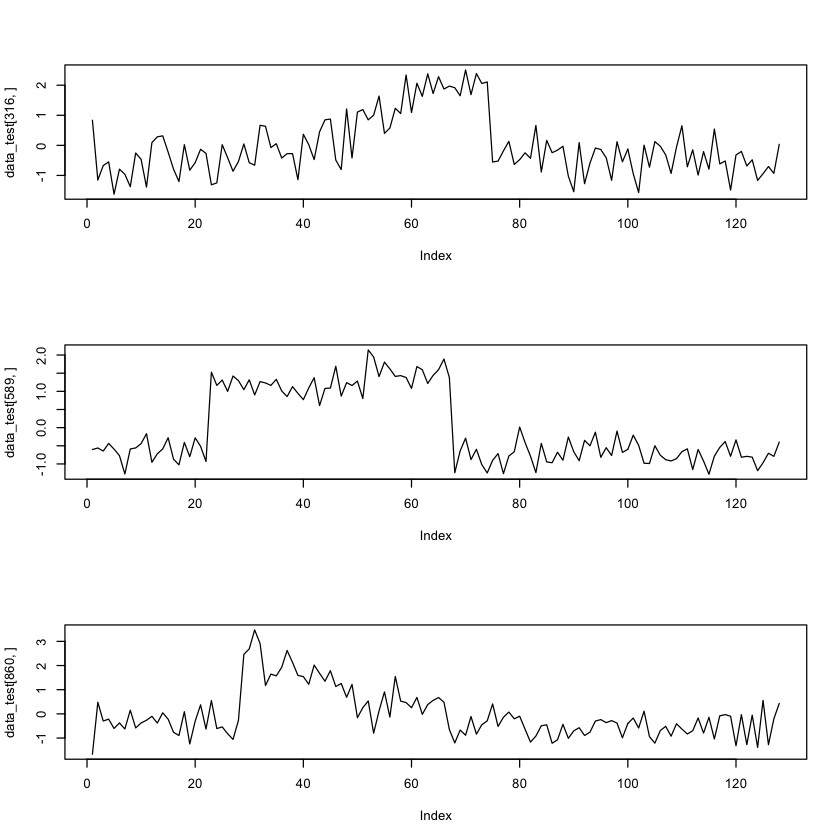

In [36]:
w = round(S$par[1], digits = 0)
p = round(S$par[2], digits = 0)
a = round(S$par[3], digits = 0)

# compute the TF-IDF vectors
#
bags <- alply(unique(train_labels),1,function(x){x})
for (j in 1:length(unique(train_labels))) {
  ll <- which(train_labels == unique(train_labels)[j])
  bags[[unique(train_labels)[j]]] <-
    manyseries_to_wordbag( train_data[ll,], w, p, a, "exact", 0.01)
}
tfidf = bags_to_tfidf(bags)

# classify the test data
#
labels_predicted = rep(-1, length(CBF[["labels_test"]]))
labels_test = CBF[["labels_test"]]
data_test = CBF[["data_test"]]
for (i in c(1:length(data_test[,1]))) {
  print(paste(i))
  series = data_test[i,]
  bag = series_to_wordbag(series, w, p, a, "exact", 0.01)
  cosines = cosine_sim(list("bag"=bag, "tfidf" = tfidf))
  if (!any(is.na(cosines$cosines))) {
    labels_predicted[i] = which(cosines$cosines == max(cosines$cosines))
  }
}

# compute the classification error
#
error = length(which((labels_test != labels_predicted))) / length(labels_test)
error

# findout which time series were misclassified
#
which((labels_test != labels_predicted))
par(mfrow=c(3,1))
plot(data_test[316,], type="l")
plot(data_test[589,], type="l")
plot(data_test[860,], type="l")

In [37]:
tfidf

,words,X1,X2,X3
1,aaaaabcccddd,0,1.523,0
2,aaaaabdddddd,0.7615,0,0
3,aaaaacbcdddd,0,0.7615,0
4,aaaaaccbdddd,0,0.7615,0
5,aaaaaccccddd,0,0.7615,0
6,aaaaaccdddcd,0.7615,0,0
7,aaaaacdddccb,0,0,0.7615
8,aaaaacdddccc,0,0,1.206949
9,aaaaacdddddd,1.206949,0,0
10,aaaaadcccddd,0.7615,0,0
